In [1]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import ipywidgets as widgets
from ipywidgets import interact
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import pyplot
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, column_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in column_names]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
#         print("This should not be happening")
        cols.append(df.shift(-i))
#         print(cols)
        if i == 0:
            names += [('{}(t)'.format(j)) for j in column_names]
        else:
            names += [('{}(t+{})'.format(j, i)) for j in column_names]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
market_data_df = pd.read_csv('Market_Data_06-11.csv', header=None)

In [4]:
market_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275687 entries, 0 to 275686
Data columns (total 11 columns):
0     275687 non-null int64
1     275687 non-null object
2     275687 non-null float64
3     275687 non-null float64
4     275687 non-null float64
5     275687 non-null float64
6     275687 non-null float64
7     275687 non-null int64
8     275687 non-null int64
9     275687 non-null object
10    275687 non-null int64
dtypes: float64(5), int64(4), object(2)
memory usage: 23.1+ MB


In [5]:
market_data_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,191861,KSE100,42858.58,11.94,0.03,42880.37,42780.91,591320,77607254,2018-06-01 09:00:05,0
1,191862,KSEALL,31376.32,14.04,0.04,31393.35,31353.03,1208720,98990460,2018-06-01 09:00:07,0
2,191863,KSE30,20951.53,-69.55,-0.33,21021.08,20901.61,542000,71496560,2018-06-01 09:00:09,0
3,191864,KMI30,72961.73,-20.35,-0.03,73099.45,72952.45,361100,61040318,2018-06-01 09:00:10,0
4,191865,PSXKMI,21401.29,19.26,0.09,21422.84,21382.03,524100,71892118,2018-06-01 09:00:11,0


In [6]:
market_data_df[1].value_counts()

KSE100    55149
KSEALL    55142
KSE30     55135
KMI30     55132
PSXKMI    55129
Name: 1, dtype: int64

In [7]:
stock_data_df = pd.read_csv('Stock_Data_06-11.csv', header=None)

In [8]:
stock_data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1159171,HBL,170.51,-0.68,-0.40,1000,170.70,171.00,400,58800,171.90,165.00,171.19,100,63,09:00:11,2018-06-01 09:00:54
1,1159172,AKBL,22.07,0.00,0.00,1500,21.52,22.60,1000,0,0.00,0.00,22.07,0,0,00:00:00,2018-06-01 09:00:54
2,1159173,FABL,25.98,0.00,0.00,5000,25.60,26.23,2500,0,0.00,0.00,25.98,0,0,00:00:00,2018-06-01 09:00:54
3,1159174,SNGP,96.70,-0.40,-0.41,1100,96.71,97.00,200,4200,97.01,96.70,97.10,100,11,08:59:35,2018-06-01 09:00:54
4,1159175,ANL,13.01,-0.15,-1.14,500,13.02,13.30,2500,1000,13.01,13.01,13.16,1000,1,08:59:42,2018-06-01 09:00:54


In [9]:
stock_data_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
2442510,3603027,DAWH,126.00,-1.20,-0.94,0,0.0,0.0,0,359200,128.00,126.00,127.20,100,55,16:07:40,2018-11-30 17:30:25
2442511,3603028,GHNI,295.44,-15.53,-4.99,0,0.0,0.0,0,91200,311.99,295.43,310.97,150,525,16:29:33,2018-11-30 17:30:25
2442512,3603029,INIL,159.50,-5.99,-3.62,0,0.0,0.0,0,10600,161.00,158.00,165.49,100,29,16:05:16,2018-11-30 17:30:25
2442513,3603030,JSBL,6.57,-0.02,-0.30,0,0.0,0.0,0,6000,6.57,6.57,6.59,1000,2,16:20:59,2018-11-30 17:30:25
2442514,3603031,PSX,16.40,-0.15,-0.91,0,0.0,0.0,0,72000,16.55,16.16,16.55,7000,39,16:29:52,2018-11-30 17:30:25


In [10]:
len(stock_data_df[1].value_counts())

45

In [11]:
len(stock_data_df)

2442515

In [12]:
# stock_data_df.index = stock_data_df[16]
stock_data_df.columns = ['id', 'symbol', 'last_price', 'change', 'change_percentage', 'bid_size', 'bid', 'offer', 'offer_size',
                         'turnover', 'high', 'low', 'open', 'last_volume', 'total_trades','last_trade', 'timestamp']

In [13]:
grouped_stock_data_dfs = stock_data_df.groupby('symbol')

In [14]:
for k, v in grouped_stock_data_dfs:
    print("Stock: {}\tLength: {}".format(k, len(v)))

Stock: AKBL	Length: 54280
Stock: ANL	Length: 54279
Stock: ATLH	Length: 54276
Stock: BAFL	Length: 54279
Stock: BOP	Length: 54279
Stock: BYCO	Length: 54279
Stock: DAWH	Length: 54276
Stock: DCL	Length: 54279
Stock: DFML	Length: 54279
Stock: DGKC	Length: 54279
Stock: ENGRO	Length: 54279
Stock: FABL	Length: 54280
Stock: FDIBL	Length: 54279
Stock: FEROZ	Length: 54279
Stock: FFBL	Length: 54279
Stock: GHNI	Length: 54276
Stock: GHNL	Length: 54279
Stock: HASCOL	Length: 54279
Stock: HBL	Length: 54282
Stock: HCAR	Length: 54279
Stock: HUBC	Length: 54279
Stock: INDU	Length: 54279
Stock: INIL	Length: 54276
Stock: ISL	Length: 54279
Stock: JSBL	Length: 54276
Stock: KAPCO	Length: 54279
Stock: KEL	Length: 54279
Stock: KOHC	Length: 54279
Stock: LUCK	Length: 54278
Stock: MARI	Length: 54278
Stock: MCB	Length: 54277
Stock: MTL	Length: 54277
Stock: NBP	Length: 54277
Stock: OGDC	Length: 54277
Stock: PAEL	Length: 54277
Stock: PASL	Length: 54277
Stock: PIAA	Length: 54277
Stock: POL	Length: 54277
Stock: POWER	Len

In [15]:
hbl_df = grouped_stock_data_dfs.get_group('HBL')

In [16]:
stock_data_df.head()

,id,symbol,last_price,change,change_percentage,bid_size,bid,offer,offer_size,turnover,high,low,open,last_volume,total_trades,last_trade,timestamp
0,1159171,HBL,170.51,-0.68,-0.40,1000,170.70,171.00,400,58800,171.90,165.00,171.19,100,63,09:00:11,2018-06-01 09:00:54
1,1159172,AKBL,22.07,0.00,0.00,1500,21.52,22.60,1000,0,0.00,0.00,22.07,0,0,00:00:00,2018-06-01 09:00:54
2,1159173,FABL,25.98,0.00,0.00,5000,25.60,26.23,2500,0,0.00,0.00,25.98,0,0,00:00:00,2018-06-01 09:00:54
3,1159174,SNGP,96.70,-0.40,-0.41,1100,96.71,97.00,200,4200,97.01,96.70,97.10,100,11,08:59:35,2018-06-01 09:00:54
4,1159175,ANL,13.01,-0.15,-1.14,500,13.02,13.30,2500,1000,13.01,13.01,13.16,1000,1,08:59:42,2018-06-01 09:00:54


In [17]:
stock_data_df.tail()

,id,symbol,last_price,change,change_percentage,bid_size,bid,offer,offer_size,turnover,high,low,open,last_volume,total_trades,last_trade,timestamp
2442510,3603027,DAWH,126.00,-1.20,-0.94,0,0.0,0.0,0,359200,128.00,126.00,127.20,100,55,16:07:40,2018-11-30 17:30:25
2442511,3603028,GHNI,295.44,-15.53,-4.99,0,0.0,0.0,0,91200,311.99,295.43,310.97,150,525,16:29:33,2018-11-30 17:30:25
2442512,3603029,INIL,159.50,-5.99,-3.62,0,0.0,0.0,0,10600,161.00,158.00,165.49,100,29,16:05:16,2018-11-30 17:30:25
2442513,3603030,JSBL,6.57,-0.02,-0.30,0,0.0,0.0,0,6000,6.57,6.57,6.59,1000,2,16:20:59,2018-11-30 17:30:25
2442514,3603031,PSX,16.40,-0.15,-0.91,0,0.0,0.0,0,72000,16.55,16.16,16.55,7000,39,16:29:52,2018-11-30 17:30:25


In [18]:
hbl_df.head(10)

,id,symbol,last_price,change,change_percentage,bid_size,bid,offer,offer_size,turnover,high,low,open,last_volume,total_trades,last_trade,timestamp
0,1159171,HBL,170.51,-0.68,-0.40,1000,170.70,171.00,400,58800,171.9,165.0,171.19,100,63,09:00:11,2018-06-01 09:00:54
45,1159216,HBL,171.00,-0.19,-0.11,1000,170.70,170.98,500,60200,171.9,165.0,171.19,500,66,09:01:00,2018-06-01 09:01:25
90,1159261,HBL,170.60,-0.59,-0.34,200,170.50,170.60,2600,73100,171.9,165.0,171.19,400,79,09:02:19,2018-06-01 09:02:28
135,1159306,HBL,170.15,-0.94,-0.55,3500,170.15,170.48,100,77800,171.9,165.0,171.19,1500,87,09:03:16,2018-06-01 09:03:25
180,1159351,HBL,170.00,-1.19,-0.70,1000,170.00,170.48,100,89500,171.9,165.0,171.19,500,95,09:03:59,2018-06-01 09:04:26
225,1159396,HBL,170.00,-1.19,-0.70,500,169.61,170.00,8000,94000,171.9,165.0,171.19,1000,98,09:05:17,2018-06-01 09:05:27
270,1159441,HBL,168.00,-3.19,-1.86,1000,167.30,168.00,4400,127600,171.9,165.0,171.19,600,133,09:06:25,2018-06-01 09:06:28
315,1159486,HBL,168.25,-2.94,-1.72,500,168.25,168.50,2000,144600,171.9,165.0,171.19,2000,153,09:07:27,2018-06-01 09:07:28
360,1159531,HBL,167.01,-4.18,-2.44,1100,167.00,167.01,400,179200,171.9,165.0,171.19,500,207,09:08:25,2018-06-01 09:08:27
405,1159576,HBL,168.00,-3.19,-1.86,400,168.00,168.45,2000,189500,171.9,165.0,171.19,100,225,09:09:21,2018-06-01 09:09:27


In [19]:
hbl_df.tail(10)

,id,symbol,last_price,change,change_percentage,bid_size,bid,offer,offer_size,turnover,high,low,open,last_volume,total_trades,last_trade,timestamp
2442065,3602582,HBL,139.86,-2.75,-1.93,78100,139.86,0.0,0,7486500,146.0,136.99,142.61,500,3701,17:01:01,2018-11-30 17:07:27
2442110,3602627,HBL,139.86,-2.75,-1.93,78100,139.86,0.0,0,7486500,146.0,136.99,142.61,500,3701,17:01:01,2018-11-30 17:08:24
2442155,3602672,HBL,139.86,-2.75,-1.93,78100,139.86,0.0,0,7486500,146.0,136.99,142.61,500,3701,17:01:01,2018-11-30 17:09:24
2442200,3602717,HBL,139.86,-2.75,-1.93,78100,139.86,0.0,0,7486500,146.0,136.99,142.61,500,3701,17:01:01,2018-11-30 17:10:24
2442245,3602762,HBL,139.86,-2.75,-1.93,12700,139.86,0.0,0,7556700,146.0,136.99,142.61,15900,3704,17:11:01,2018-11-30 17:11:24
2442290,3602807,HBL,139.86,-2.75,-1.93,22700,139.86,0.0,0,7556700,146.0,136.99,142.61,15900,3704,17:11:01,2018-11-30 17:12:24
2442335,3602852,HBL,139.86,-2.75,-1.93,22700,139.86,0.0,0,7556700,146.0,136.99,142.61,15900,3704,17:11:01,2018-11-30 17:13:24
2442380,3602897,HBL,139.86,-2.75,-1.93,22700,139.86,0.0,0,7556700,146.0,136.99,142.61,15900,3704,17:11:01,2018-11-30 17:14:24
2442425,3602942,HBL,139.86,-2.75,-1.93,22700,139.86,0.0,0,7556700,146.0,136.99,142.61,15900,3704,17:11:01,2018-11-30 17:15:25
2442470,3602987,HBL,139.86,-2.75,-1.93,22700,139.86,0.0,0,7556700,146.0,136.99,142.61,15900,3704,17:11:01,2018-11-30 17:30:24


In [20]:
print(len(hbl_df))
hbl_train, hbl_test = train_test_split(hbl_df, shuffle=False, train_size=0.7)
print(len(hbl_train), len(hbl_test))

54282
37997 16285


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [21]:
hbl_train.tail(10)

,id,symbol,last_price,change,change_percentage,bid_size,bid,offer,offer_size,turnover,high,low,open,last_volume,total_trades,last_trade,timestamp
1709290,2869807,HBL,135.99,1.04,0.77,100,135.60,135.99,200,2952400,141.69,134.0,134.95,400,984,11:21:25,2018-10-09 11:22:24
1709335,2869852,HBL,135.99,1.04,0.77,100,135.60,135.99,200,2952400,141.69,134.0,134.95,400,984,11:21:25,2018-10-09 11:23:25
1709380,2869897,HBL,135.99,1.04,0.77,100,135.60,135.90,1000,2952400,141.69,134.0,134.95,400,984,11:21:25,2018-10-09 11:24:25
1709425,2869942,HBL,135.99,1.04,0.77,100,135.60,135.90,1000,2952400,141.69,134.0,134.95,400,984,11:21:25,2018-10-09 11:25:24
1709470,2869987,HBL,135.90,0.95,0.70,100,135.60,135.98,3000,2953400,141.69,134.0,134.95,700,986,11:25:38,2018-10-09 11:26:23
1709515,2870032,HBL,135.99,1.04,0.77,300,135.99,136.00,1500,2953600,141.69,134.0,134.95,200,987,11:27:25,2018-10-09 11:27:26
1709560,2870077,HBL,136.00,1.05,0.78,300,136.01,136.75,2500,2955200,141.69,134.0,134.95,100,989,11:28:00,2018-10-09 11:28:24
1709605,2870122,HBL,136.00,1.05,0.78,1000,136.10,136.69,100,2955200,141.69,134.0,134.95,100,989,11:28:00,2018-10-09 11:29:28
1709650,2870167,HBL,136.00,1.05,0.78,2000,136.11,136.50,2500,2955200,141.69,134.0,134.95,100,989,11:28:00,2018-10-09 11:30:26
1709695,2870212,HBL,136.50,1.55,1.15,100,136.15,136.50,2400,2955300,141.69,134.0,134.95,100,990,11:30:35,2018-10-09 11:31:23


In [22]:
hbl_test.head(10)

,id,symbol,last_price,change,change_percentage,bid_size,bid,offer,offer_size,turnover,high,low,open,last_volume,total_trades,last_trade,timestamp
1709740,2870257,HBL,136.50,1.55,1.15,1000,136.51,136.89,500,2958200,141.69,134.0,134.95,500,992,11:31:52,2018-10-09 11:32:24
1709785,2870302,HBL,136.50,1.55,1.15,1000,136.51,136.89,600,2958200,141.69,134.0,134.95,500,992,11:31:52,2018-10-09 11:33:25
1709830,2870347,HBL,136.90,1.95,1.44,1000,136.51,136.90,200,2963200,141.69,134.0,134.95,300,998,11:34:23,2018-10-09 11:34:25
1709875,2870392,HBL,136.50,1.55,1.15,100,136.15,136.50,400,2971300,141.69,134.0,134.95,7100,1000,11:35:17,2018-10-09 11:35:24
1709920,2870437,HBL,136.11,1.16,0.86,1900,136.11,136.49,100,2971500,141.69,134.0,134.95,100,1002,11:36:00,2018-10-09 11:36:24
1709965,2870482,HBL,136.11,1.16,0.86,300,136.05,136.48,200,2971600,141.69,134.0,134.95,100,1003,11:36:37,2018-10-09 11:37:25
1710010,2870527,HBL,136.11,1.16,0.86,1000,136.05,136.48,200,2971600,141.69,134.0,134.95,100,1003,11:36:37,2018-10-09 11:38:24
1710055,2870572,HBL,136.45,1.50,1.11,1000,136.02,136.30,200,2972100,141.69,134.0,134.95,500,1004,11:38:40,2018-10-09 11:39:24
1710100,2870617,HBL,136.45,1.50,1.11,1000,136.02,136.30,200,2972100,141.69,134.0,134.95,500,1004,11:38:40,2018-10-09 11:40:27
1710145,2870662,HBL,136.45,1.50,1.11,1000,136.02,136.30,200,2972100,141.69,134.0,134.95,500,1004,11:38:40,2018-10-09 11:41:24


In [23]:
proph_df = hbl_df[['timestamp', 'last_price']]
proph_df.columns = ['ds', 'y']
proph_df.head()

,ds,y
0,2018-06-01 09:00:54,170.51
45,2018-06-01 09:01:25,171.00
90,2018-06-01 09:02:28,170.60
135,2018-06-01 09:03:25,170.15
180,2018-06-01 09:04:26,170.00


In [24]:
proph_df.tail()

,ds,y
2442290,2018-11-30 17:12:24,139.86
2442335,2018-11-30 17:13:24,139.86
2442380,2018-11-30 17:14:24,139.86
2442425,2018-11-30 17:15:25,139.86
2442470,2018-11-30 17:30:24,139.86


In [25]:
df = pd.DataFrame({'value': proph_df['y'].values})

In [26]:
df

,value
0,170.51
1,171.00
2,170.60
3,170.15
4,170.00
5,170.00
6,168.00
7,168.25
8,167.01
9,168.00


In [27]:
# Import data
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

In [28]:
# df

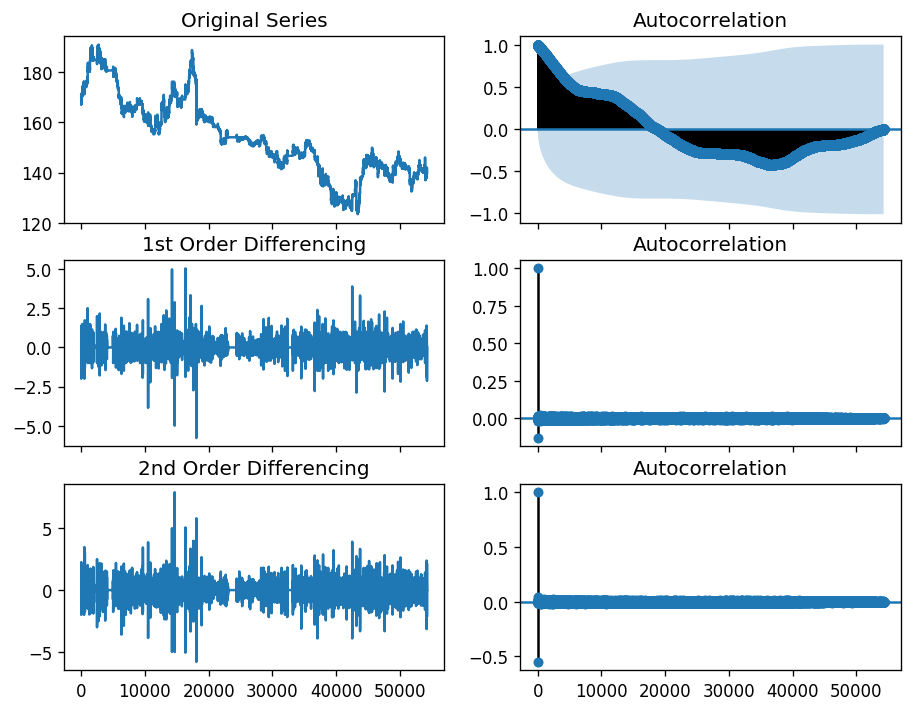

In [29]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [30]:
from pmdarima.arima.utils import ndiffs
y = df.value

## Adf Test
print(ndiffs(y, test='adf'))  # 1

# KPSS test
print(ndiffs(y, test='kpss'))  # 1

# PP test:
print(ndiffs(y, test='pp'))  # 1

1
1
1


In [31]:
# # PACF plot of 1st differenced series
# plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# fig, axes = plt.subplots(1, 2, sharex=True)
# axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
# axes[1].set(ylim=(0,5))
# plot_pacf(df.value.diff().dropna(), ax=axes[1])

# plt.show()

In [32]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.354184
p-value: 0.604033


In [35]:
# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                54281
Model:                 ARIMA(1, 1, 2)   Log Likelihood                5568.904
Method:                       css-mle   S.D. of innovations              0.218
Date:                Sun, 17 Mar 2019   AIC                         -11127.808
Time:                        09:36:35   BIC                         -11083.299
Sample:                             1   HQIC                        -11113.919
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0006      0.001     -0.780      0.436      -0.002       0.001
ar.L1.D.value     0.8530      0.036     23.600      0.000       0.782       0.924
ma.L1.D.value    -0.9927      0.037    -

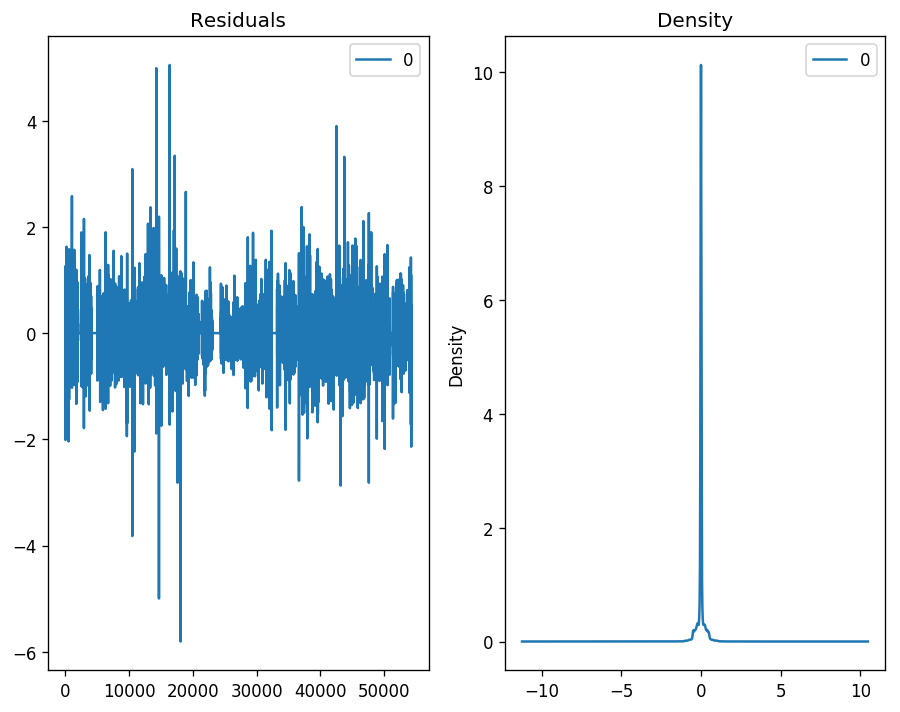

In [36]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

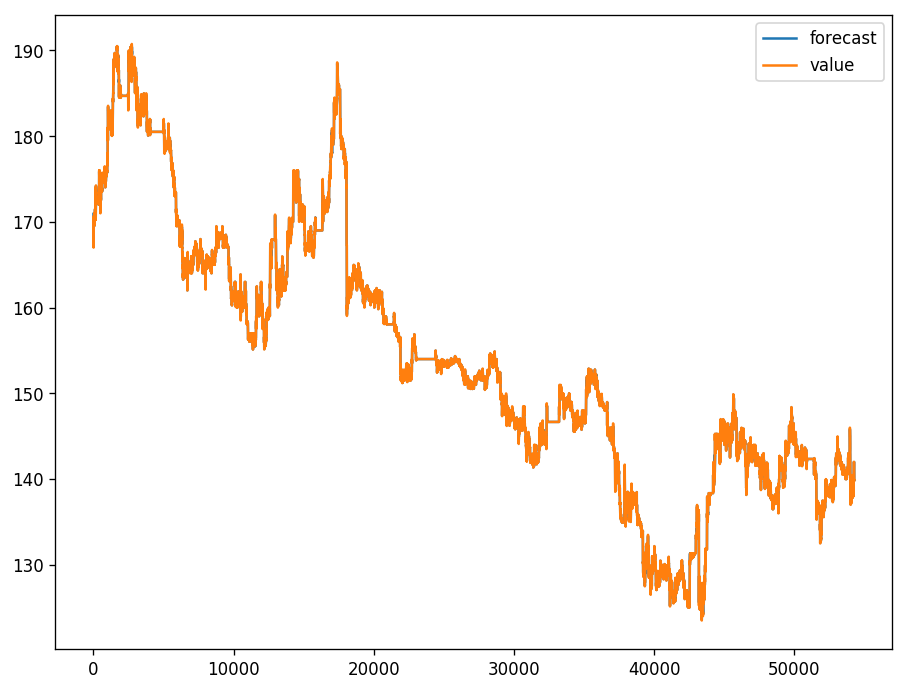

In [37]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [38]:
len(df)

54282

In [39]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:45000]
test = df.value[45000:]

In [40]:
len(train), len(test)

(45000, 9282)

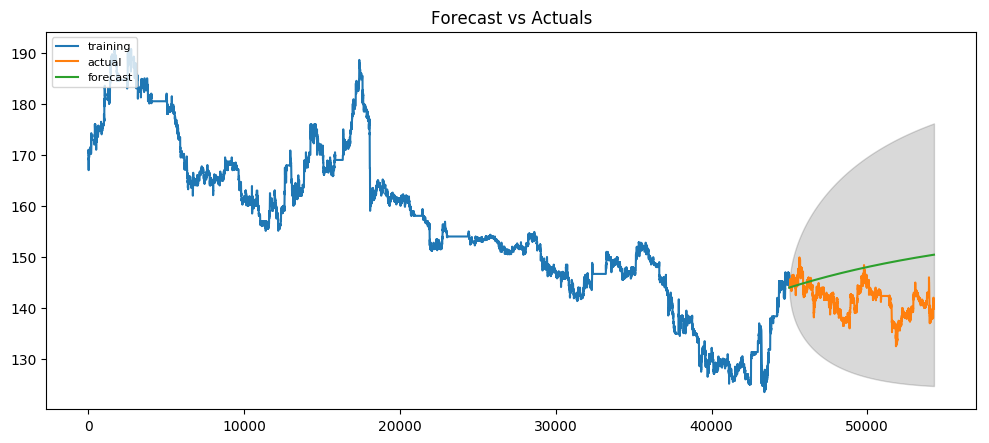

In [41]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 0, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                44998
Model:                ARIMA(10, 2, 7)   Log Likelihood                5209.933
Method:                       css-mle   S.D. of innovations              0.216
Date:                Sun, 17 Mar 2019   AIC                         -10381.865
Time:                        05:51:51   BIC                         -10216.292
Sample:                             2   HQIC                        -10329.745
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.308e-07   2.12e-06     -0.062      0.951   -4.29e-06    4.03e-06
ar.L1.D2.value     -1.2193      0.137     -8.890      0.000      -1.488      -0.950
ar.L2.D2.value     -1.6686      

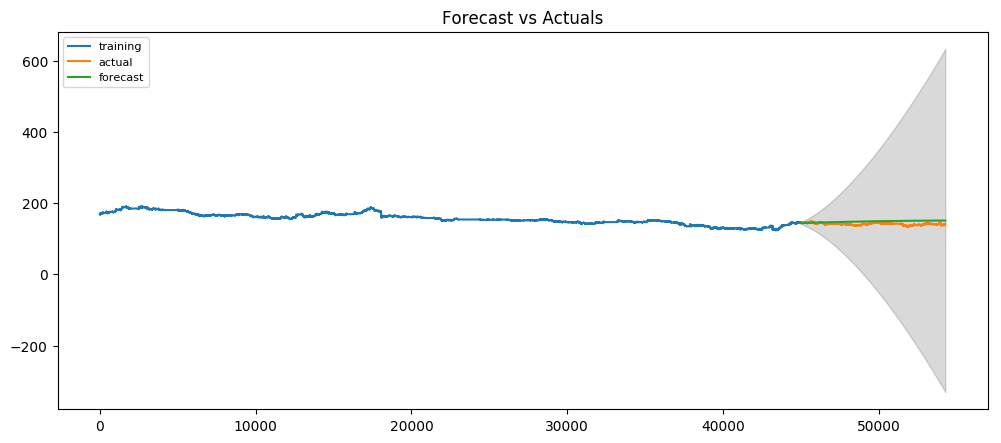

In [80]:
# Build Model
model = ARIMA(train, order=(10, 2, 7))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [81]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'acf1': 0.9983302135885276,
 'corr': -0.4973354299597611,
 'mae': 7.13547071110377,
 'mape': 0.05091351553296741,
 'me': 6.9108866010873715,
 'minmax': 0.047738414731058776,
 'mpe': 0.04938433405793948,
 'rmse': 8.153118751272547}

In [88]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Yes Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-11113.817, BIC=-11078.209, Fit time=12.707 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-10062.692, BIC=-10044.888, Fit time=4.155 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-11021.781, BIC=-10995.075, Fit time=2.898 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-11086.003, BIC=-11059.297, Fit time=4.985 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-11113.338, BIC=-11068.828, Fit time=34.836 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-11110.735, BIC=-11066.225, Fit time=8.985 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-11110.410, BIC=-11056.999, Fit time=19.373 seconds
Total fit time: 88.493 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                54282
Model:               SARIMAX(1,

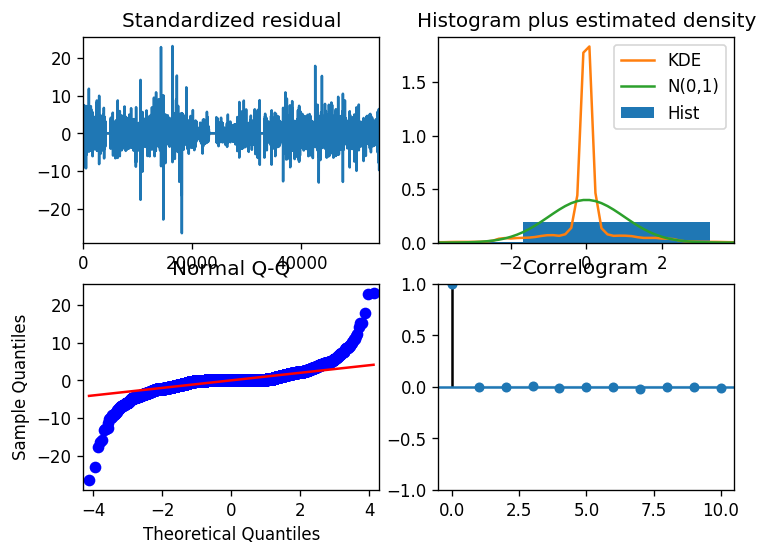

In [89]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

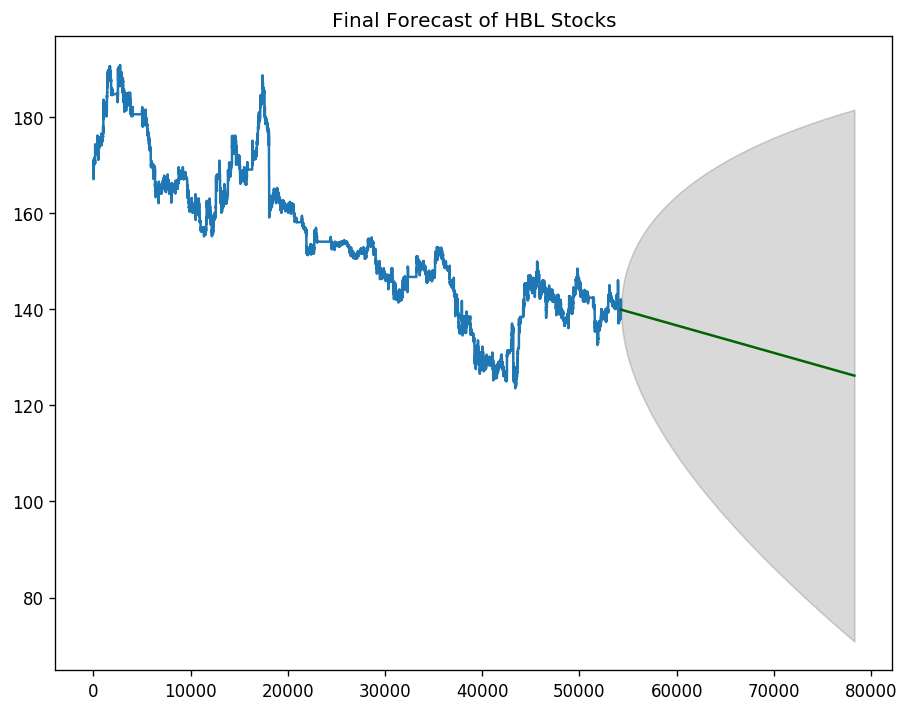

In [90]:
# Forecast
n_periods = 24000
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of HBL Stocks")
plt.show()

In [42]:
df2 = proph_df.copy()
df2.reset_index(inplace=True)
df2['Date'] = pd.to_datetime(df2['ds'])
df2 = df2.set_index('Date')

In [43]:
df2.drop(columns=['index', 'ds'], inplace=True)

In [44]:
df2

,y
Date,
2018-06-01 09:00:54,170.51
2018-06-01 09:01:25,171.00
2018-06-01 09:02:28,170.60
2018-06-01 09:03:25,170.15
2018-06-01 09:04:26,170.00
2018-06-01 09:05:27,170.00
2018-06-01 09:06:28,168.00
2018-06-01 09:07:28,168.25
2018-06-01 09:08:27,167.01


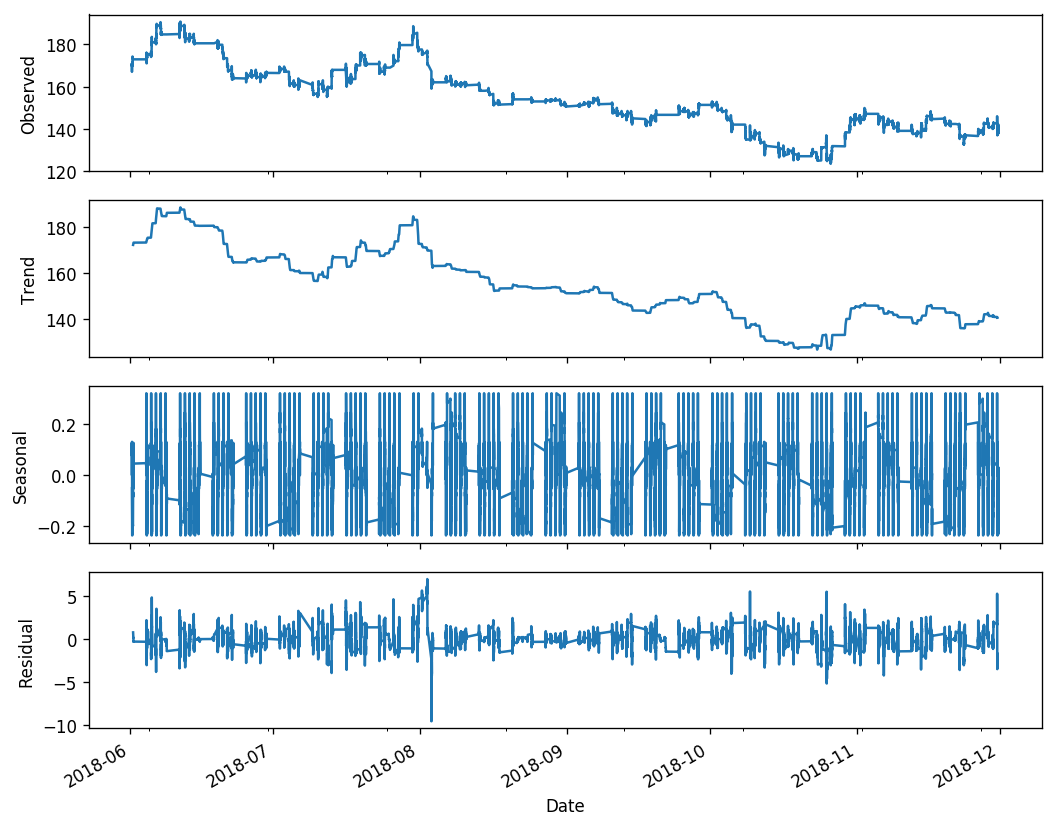

In [45]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df2, model='additive', freq=450)
fig = decomposition.plot()
plt.show()

In [134]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [137]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:701408.4908252652
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:626414.5347634727
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:104617.79415458423
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:104180.502440039
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:104623.71349479433


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:104258.18597752905
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:104176.62038700812
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:104150.40176376767
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:626280.0892388892
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:551457.4442757546
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:64521.32753907794
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:62078.93436511615


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:64537.58286483192


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:124982.72472151452
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:62131.45064240553
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:62075.03164216221
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-10068.087424551786
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-10265.084682228502
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:28160.17746007756
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-10076.421002231014
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-10258.722456066293
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-10263.11982726416
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:11549.372938619503
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-10162.461988514837
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-11092.173134275974
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-11286.150326332176
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:27245.009150093043
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-11094.99344684812
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-11280.80988525652
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-11284.419110270812
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:10539.

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-10256.979162124908
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:24734.908217606564
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-10063.154127081529
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-10256.56080876762


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-10085.434610207774
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:9426.771150425444
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-10151.214501415425
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-11088.129440328721


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-11281.564378061428
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:24490.1337770344


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-11095.981392817732
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-11278.789269405988
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-11148.481699207216
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:8918.379423672006
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-11184.02609766189
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-11027.066107463635
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-11221.101991427502
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:27291.180424492144
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-11031.59515558448
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-11221.09852505935
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-11219.214695862032
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:10592.22514061351
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-11117.036819462695
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-11119.38481124751
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-11317.343618504097
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:27231.836566067384
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-11123.304087319848
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-113

In [46]:
mod = SARIMAX(df2,
              order=(1, 0, 1),
              seasonal_order=(1, 1, 0, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9384      0.001   1260.450      0.000       0.937       0.940
ma.L1         -0.1048      0.003    -41.543      0.000      -0.110      -0.100
ar.S.L12      -0.5040      0.001   -387.610      0.000      -0.507      -0.501
sigma2         0.0690      0.000    604.655      0.000       0.069       0.069


In [47]:
df = pd.read_csv('sample_solution.csv')

In [48]:
df.head()

,id,symbol,last_price,timestamp
0,3603032,HBL,18.60,03/12/2018 9:00
1,3603033,AKBL,13.43,03/12/2018 9:00
2,3603034,FABL,17.35,03/12/2018 9:00
3,3603035,SNGP,20.44,03/12/2018 9:00
4,3603036,ANL,24.18,03/12/2018 9:00


In [49]:
dfg = df.groupby('symbol')

In [51]:
d = {}
for k, v in dfg:
    print(k, len(v))
    d[k] = len(v)

AKBL 17158
ANL 17157
ATLH 7601
BAFL 17157
BOP 17157
BYCO 17156
DAWH 17156
DCL 17156
DFML 17156
DGKC 17156
ENGRO 17156
FABL 17158
FDIBL 15451
FEROZ 17156
FFBL 17156
GHNI 17156
GHNL 17156
HASCOL 16412
HBL 17158
HCAR 17156
HUBC 17156
INDU 15462
INIL 17156
ISL 17156
JSBL 9126
KAPCO 17156
KEL 17156
KOHC 17156
LUCK 17156
MARI 17156
MCB 17156
MTL 15906
NBP 17156
OGDC 17156
PAEL 17156
PASL 15144
PIAA 17156
POL 17156
POWER 16318
PPL 17156
PSX 15204
SEARL 16487
SNGP 17157
SSGC 17156
UBL 17156


In [52]:
d

{'AKBL': 17158,
 'ANL': 17157,
 'ATLH': 7601,
 'BAFL': 17157,
 'BOP': 17157,
 'BYCO': 17156,
 'DAWH': 17156,
 'DCL': 17156,
 'DFML': 17156,
 'DGKC': 17156,
 'ENGRO': 17156,
 'FABL': 17158,
 'FDIBL': 15451,
 'FEROZ': 17156,
 'FFBL': 17156,
 'GHNI': 17156,
 'GHNL': 17156,
 'HASCOL': 16412,
 'HBL': 17158,
 'HCAR': 17156,
 'HUBC': 17156,
 'INDU': 15462,
 'INIL': 17156,
 'ISL': 17156,
 'JSBL': 9126,
 'KAPCO': 17156,
 'KEL': 17156,
 'KOHC': 17156,
 'LUCK': 17156,
 'MARI': 17156,
 'MCB': 17156,
 'MTL': 15906,
 'NBP': 17156,
 'OGDC': 17156,
 'PAEL': 17156,
 'PASL': 15144,
 'PIAA': 17156,
 'POL': 17156,
 'POWER': 16318,
 'PPL': 17156,
 'PSX': 15204,
 'SEARL': 16487,
 'SNGP': 17157,
 'SSGC': 17156,
 'UBL': 17156}

In [53]:
os.listdir()

['.~lock.Stock_Data_06-11.csv#',
 'BOP_preds.csv',
 'ATLH_preds.csv',
 '__MACOSX',
 'AKBL_preds.csv',
 '.~lock.sample_solution.csv#',
 '.ipynb_checkpoints',
 '.~lock.Market_Data_06-11.csv#',
 'Stock_Data_06-11.csv',
 'Market_Data_06-11.csv',
 'sample_solution.csv',
 'ANL_preds.csv',
 'Untitled.ipynb',
 'BAFL_preds.csv']

In [54]:
files = ['BOP_preds.csv', 'ATLH_preds.csv', 'AKBL_preds.csv', 'ANL_preds.csv', 'BAFL_preds.csv']

In [55]:
to_add = {
    'BOP': 1,
    'ATHL': 2,
    'AKBL': 3,
    'ANL': 4,
    'BAFL': 5
}

In [ ]:
for k, v in dfg:
    if k == 'BOP':
        td = pd.read_csv('BOP_preds.csv')
        v.last_price = td.preds
        
    elif k == 'ATHL':
        td = pd.read_csv('BOP_preds.csv')
        v.last_price = td.preds
        
    elif k == 'AKBL':
        td = pd.read_csv('BOP_preds.csv')
        v.last_price = td.preds
    elif k == 'ATHL':
        td = pd.read_csv('BOP_preds.csv')
        v.last_price = td.preds
        
    elif k == 'ATHL':
        td = pd.read_csv('BOP_preds.csv')
        v.last_price = td.preds